In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Hopfield network storing and recall rules

In [68]:
T_MAX = 1000


def store(weights, memory, n):
    if weights.shape[0] != memory.shape[0]:
        raise ValueError('Weights and memory should have same first dimension')
        
    if 1 == len(memory.shape):
        memory = memory[:, np.newaxis]
        
    weights = ((n - 1) * weights + memory.dot(memory.T)) / n
    weights = weights - np.diag(np.diag(weights))  # clear out the diagonal
    
    return weights


def binary_activation(x):
    return np.where(x > 0, 1, -1)
    
    
def synchronous_recall(weights, memory, 
                       activation_func=binary_activation, 
                       t_max=T_MAX,
                       debug=False):
    x_prev = memory
    
    for t in range(t_max):
        a = weights.dot(x_prev)
        x = activation_func(a)
        if debug: print(x_prev, x)
        if np.all(x_prev == x):
            return x
        
        x_prev = x
        
    raise ValueError('Failed to converge in {t} iterations'.format(t=t_max))
    

def asynchronous_recall(weights, memory, 
                       activation_func=binary_activation, 
                       t_max=T_MAX,
                       debug=False):
    x_prev = memory
    
    for t in range(t_max):
        x = x_prev.copy()
        order = np.asarray(range(weights.shape[0]))
        np.random.shuffle(order)
        
        for i in order:
            a_i = weights[i,:].dot(x)
            x[i] = activation_func(a_i)
            
            
        if debug: print(x_prev, x)
        if np.all(x_prev == x):
            return x
        
        x_prev = x
        
    raise ValueError('Failed to converge in {t} iterations'.format(t=t_max))

Quick test

In [69]:
memory = np.asarray([1, 1, 1, -1, -1, -1])
weights = np.zeros((6, 6))

weights = store(weights, memory, 1)
print(weights)
print(synchronous_recall(weights, np.asarray([1, 1, -1, -1, -1, -1]), t_max=10))

[[ 0.  1.  1. -1. -1. -1.]
 [ 1.  0.  1. -1. -1. -1.]
 [ 1.  1.  0. -1. -1. -1.]
 [-1. -1. -1.  0.  1.  1.]
 [-1. -1. -1.  1.  0.  1.]
 [-1. -1. -1.  1.  1.  0.]]
[ 1  1  1 -1 -1 -1]


## Capacity test and scaling behavior

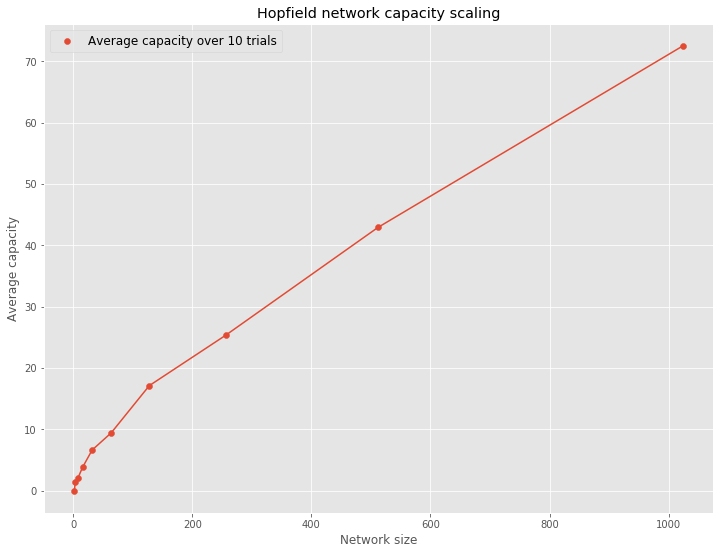

In [83]:
FONT_SIZE = 12


def capacity(n, recall_rule=synchronous_recall,
             activation_func=binary_activation, 
             t_max=T_MAX):
    weights = np.zeros((n, n))
    recalls = 0
    
    while True:
        memory = np.random.choice((1, -1), (n, 1))
        weights = store(weights, memory, recalls + 1)
        
        corrupted_memory = memory.copy()
        corrupted_memory[np.random.randint(0, n)] *= -1
    
        try:
            result = recall_rule(weights, corrupted_memory, 
                                 activation_func, t_max)
            
            if not np.all(result == memory):
                break
                
            recalls += 1
            
        except ValueError:
            break
            
    return recalls


def scaling_behavior(n_values, repeat=10, logx=False, logy=False,
                    recall_rule=synchronous_recall,
                    activation_func=binary_activation, 
                    t_max=T_MAX):
    
    results = [np.mean([capacity(n, recall_rule, activation_func, t_max)
                       for _ in range(repeat)]) 
               for n in n_values]
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111) 
    ax.scatter(n_values, results, label='Average capacity over {r} trials'.format(r=repeat))
    ax.plot(n_values, results)
    
    if logx:
        ax.set_xscale("log", nonposx='clip')

    if logy:
        ax.set_yscale("log", nonposy='clip')
        
    ax.legend(loc=2, fontsize=FONT_SIZE)
    ax.set_xlabel('Network size', size=FONT_SIZE)
    ax.set_ylabel('Average capacity', size=FONT_SIZE)
    ax.set_title('Hopfield network capacity scaling')
    
    plt.show()
    
    
scaling_behavior([2 ** x for x in range(1, 11)])

array([ 1,  1, -1,  1, -1, -1])